<a href="https://colab.research.google.com/github/xiaowei07/covid19_eda/blob/master/tsGANs(linear).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from IPython.display import clear_output
from torchsummary import summary

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

In [3]:
seed = 1234
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

In [4]:
df = pd.read_csv('/content/drive/My Drive/data.csv',index_col=0)
df = df[pd.notnull(df['y'])]


df['y'] = df['y'].apply(lambda x : 1 if x > 1 else 0)

In [5]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,1
X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,0
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,1
X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,1
X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,1


In [6]:
df1 = df[df['y'] == 1]
df0 = df[df['y'] == 0]

In [7]:
df1 = df1.sample(df0.shape[0])

In [8]:
df_balanced = pd.concat((df0, df1)).sample(frac=1)

In [9]:
df_balanced.y.value_counts()

1    2300
0    2300
Name: y, dtype: int64

In [10]:
df_preprocess = df_balanced

### Classifier

In [11]:
train, validate, test = np.split(
    df_preprocess.sample(frac=1, random_state=seed), 
    [int(.6*len(df_preprocess)), int(.8*len(df_preprocess))])  # split at 0.6 and 0.8 -- split into 3 pieces.

In [12]:
train.shape, validate.shape, test.shape

((2760, 179), (920, 179), (920, 179))

In [13]:
# Remove the label column from X and create a label vectors.
X_train = train.drop(['y'], axis=1).values
y_train = train['y'].values

X_val = validate.drop(['y'], axis=1).values
y_val = validate['y'].values

X_test = test.drop(['y'], axis=1).values
y_test = test['y'].values

In [14]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())

val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [15]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [16]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(178, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [17]:
def cost_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

In [18]:
neural_net = NeuralNet()
neural_net = neural_net.to(device)
# Eval mode activation
neural_net = neural_net.eval()

In [19]:
optimizer = optim.Adam(neural_net.parameters(), lr=0.001)

In [20]:
train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an evaluation batch.


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

In [21]:
def train_loop(epoch, model, train_loader, optimizer, device):
    
    # activate the training mode
    model.train()
    
    torch.set_grad_enabled(True)
    
    total_loss = 0
    correct = 0
    
    # iteration over the mini-batches
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        
        # reinitialize the gradients to zero
        optimizer.zero_grad()
        
        # forward propagation on the data
        prediction = model(data)
        
        # compute the cost function w.r.t. the targets
        loss = cost_function(prediction, target)
        
        # execute the backpropagation
        loss.backward(retain_graph=True)
        
        # execute an optimization step
        optimizer.step()
        
        # accumulate the loss
        total_loss += loss.item()*len(data)
        
        # compute the number of correct predictions
        _, pred_classes = torch.max(prediction, dim=1)        
        correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()
         
        
    # compute the average cost per epoch
    mean_loss = total_loss/len(train_loader.dataset)
    
    # compute the accuracy
    acc = correct / len(train_loader.dataset)
        
    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))   
    
    # return the average loss and the accuracy
    return mean_loss, acc

In [22]:
def evaluate(model, eval_loader, device):
    
    # activate the evaluation mode
    model.eval()
    
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
    
        # iterate over the batches
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transfer the data on the chosen device
            data, target = data.to(device), target.to(device)

            # forward propagation on the data
            prediction = model(data)

            # compute the cost function w.r.t. the targets
            loss = cost_function(prediction, target)           


            # accumulate the loss
            total_loss += loss.item()*len(data)

            # compute the number of correct predictions en sortie)
            _, pred_classes = torch.max(prediction, dim=1) 
            correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()         
          
    
    # compute the average cost per epoch
    mean_loss = total_loss/len(eval_loader.dataset)
    
    # compute the accuracy
    acc = correct / len(eval_loader.dataset)
        
    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc)) 
    
    # return the average loss and the accuracy
    return mean_loss, acc

In [23]:
def save_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # saving the model parameters
    torch.save(model.state_dict(), filename)
    
    
    return model

In [24]:
def load_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # loading the parameters of the saved model
    model.load_state_dict(torch.load(filename))
    
    
    return model

In [25]:
# maximum number of epoch
numEpochs = 10

# Saving frequency
checkpoint_freq = 10

# Directory for data backup
path = './'

# Accumulators of average costs obtained per epoch
train_losses = []
val_losses = []

# Performance accumulators per epoch
train_accuracies = []
val_accuracies = []

# Model definition
neural_net = NeuralNet()

# Load the model on the chosen device
neural_net = neural_net.to(device)

# Optimizer definition
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 


# Learning loop
for epoch in range(1, numEpochs + 1):
    
    # train the model with the train dataset
    train_loss, train_acc = train_loop(epoch, neural_net, train_loader, optimizer, device)   
    
    # evaluate the model with the validation dataset
    val_loss, val_acc = evaluate(neural_net, val_loader, device)       
    
    # Save the costs obtained
    train_losses.append(train_loss)    
    val_losses.append(val_loss)
    
    # Save the performances
    train_accuracies.append(train_acc)    
    val_accuracies.append(val_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path)

# Save the model at the end of the training
save_model(numEpochs, neural_net, path)
    
print("\n\n\nOptimization ended.\n")

Train Epoch: 1   Avg_Loss: 9.24458   Acc: 1841/2760 (66.703%)
Eval:  Avg_Loss: 0.44176   Acc: 695/920 (75.543%)
Train Epoch: 2   Avg_Loss: 0.35623   Acc: 2183/2760 (79.094%)
Eval:  Avg_Loss: 0.36280   Acc: 740/920 (80.435%)
Train Epoch: 3   Avg_Loss: 0.31365   Acc: 2354/2760 (85.290%)
Eval:  Avg_Loss: 0.36787   Acc: 743/920 (80.761%)
Train Epoch: 4   Avg_Loss: 0.26567   Acc: 2467/2760 (89.384%)
Eval:  Avg_Loss: 0.35770   Acc: 780/920 (84.783%)
Train Epoch: 5   Avg_Loss: 0.28089   Acc: 2455/2760 (88.949%)
Eval:  Avg_Loss: 0.39541   Acc: 765/920 (83.152%)
Train Epoch: 6   Avg_Loss: 0.24497   Acc: 2526/2760 (91.522%)
Eval:  Avg_Loss: 0.36237   Acc: 778/920 (84.565%)
Train Epoch: 7   Avg_Loss: 0.22114   Acc: 2597/2760 (94.094%)
Eval:  Avg_Loss: 0.42714   Acc: 754/920 (81.957%)
Train Epoch: 8   Avg_Loss: 0.18481   Acc: 2626/2760 (95.145%)
Eval:  Avg_Loss: 0.43630   Acc: 766/920 (83.261%)
Train Epoch: 9   Avg_Loss: 0.19363   Acc: 2615/2760 (94.746%)
Eval:  Avg_Loss: 0.39498   Acc: 793/920 (8

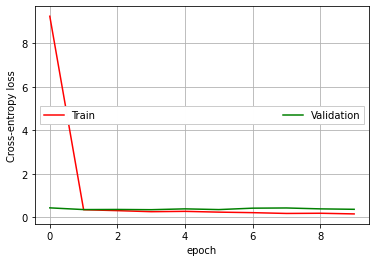

In [26]:
x = list(range(len(train_losses)))

ax = plt.subplot(111)
plt.plot(x, train_losses, 'r', label="Train")
plt.plot(x, val_losses, 'g', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

In [27]:
test_loss, test_acc = evaluate(neural_net, test_loader, device)

Eval:  Avg_Loss: 0.40587   Acc: 799/920 (86.848%)


### GANs

#### Generator and Discriminator

In [28]:
z_dim = 32

In [29]:
class Generator(nn.Module):
  """
  Generator Class
  Values:
      input_dim: the dimension of the input vector, a scaler
      ts_chan: the number of channels in the time series, fitted for the dataset used, a scaler
      hidden_dim: the inner dimension, a scaler
  """
  def __init__(self,input_dim=66,hidden_dim=132,output_dim=178):
    super(Generator,self).__init__()
    self.input_dim = input_dim
    self.gen = nn.Sequential(
        nn.Linear(input_dim,hidden_dim),
        # nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim,output_dim),
        nn.Tanh()
    )

  def forward(self,noise):
    # x = noise.view(len(noise),self.input_dim,1)  # change the noise shape from (64,178) to(64,178,1,1)
    return self.gen(noise)

In [30]:
class Discriminator(nn.Module):
  """
  Discriminator Class
  Values:
    ts_chan: the number of channels in the time series
    hidden_dim: the inner dimension, a scaler
    [32,3,178] -> [32,2,30] -> [32,1,1]
  """
  def __init__(self, ts_chan=3, hidden_chan=2, output_chan=1,kernel_size=[28,31],stride=5):
    super(Discriminator,self).__init__()
    self.disc = nn.Sequential(
        self.make_gen_block(ts_chan,hidden_chan,kernel_size=kernel_size[0],stride=stride),
        self.make_gen_block(hidden_chan,output_chan,kernel_size=kernel_size[1],stride=stride,final_layer=True),
    )
  
  def make_gen_block(self, input_channels,output_channels,kernel_size=3,stride=1,final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv1d(input_channels,output_channels,kernel_size,stride),
          nn.BatchNorm1d(output_channels),
          nn.LeakyReLU(0.2, inplace=True),
      )
    else:
      return nn.Sequential(
          nn.Conv1d(input_channels,output_channels,kernel_size,stride),
          nn.BatchNorm1d(output_channels),
          nn.Sigmoid()
      )
  # def __init__(self, ts_chan=3, output_chan=1,kernel_size=178,stride=4):
  #   super(Discriminator,self).__init__()
  #   self.disc = nn.Sequential(
  #       self.make_gen_block(ts_chan,output_chan,kernel_size=kernel_size,stride=stride),
  #   )
  
  # def make_gen_block(self, input_channels,output_channels,kernel_size=3,stride=1):
  #   return nn.Sequential(
  #         nn.Conv1d(input_channels,output_channels,kernel_size,stride),
  #         nn.BatchNorm1d(output_channels),
  #         # nn.LeakyReLU(0.2, inplace=True),
  #         nn.Sigmoid()
  #     )
  
  def forward(self,ts):
    """
    Function for completing a forward pass of the discriminator: given a time series tensor,
    returns a 1-dim tensor representing fake/real.

    Parameters:
      ts: a time series tensor with dimension(ts_chan)
    """
    # ts = ts.view(ts.shape[0],ts.shape[1],1)
    disc_pred = self.disc(ts)
    return disc_pred

In [31]:
device = 'cpu'
gen = Generator(input_dim=z_dim+2).to(device)
disc = Discriminator().to(device)

In [33]:
summary(gen,(1,z_dim+2)) #shape of input is required as a part of the argument.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 132]           4,620
            Linear-2               [-1, 1, 178]          23,674
              Tanh-3               [-1, 1, 178]               0
Total params: 28,294
Trainable params: 28,294
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


#### DataLoader

##### Original DataLoader

In [34]:
lr_d = 0.0000001
lr_g = 0.001
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr_d)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr_g)

In [35]:
nepochs = 2000
criterion = nn.BCELoss()
display_step = 1000
batch_size = 32
# device = 'cuda'
n_classes = 2
z_dim = 32 # noise dimension
transform = transforms.ToTensor()

In [36]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Normalized DataLoader

In [37]:
df_normalize = df_preprocess.copy()

In [38]:
df_X_norm = df_normalize.drop(['y'], axis=1)
df_y_norm = df_normalize['y']

In [39]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

In [40]:
df_X_norm.iloc[:,:] = Normalizer(norm='l2').fit_transform(df_X_norm)
# df_X_norm.iloc[:,:] = MinMaxScaler(feature_range=[0,1]).fit_transform(df_X_norm)

In [41]:
df_X_norm['y'] = df_y_norm

In [42]:
train_n, validate_n, test_n = np.split(
    df_X_norm.sample(frac=1, random_state=seed), 
    [int(.6*len(df_X_norm)), int(.8*len(df_X_norm))])

In [43]:
X_train_n = train_n.drop(['y'], axis=1).values
y_train_n = train_n['y'].values

X_val_n = validate_n.drop(['y'], axis=1).values
y_val_n = validate_n['y'].values

X_test_n = test_n.drop(['y'], axis=1).values
y_test_n = test_n['y'].values

In [44]:
train_dataset = TensorDataset(torch.from_numpy(X_train_n).float(), torch.from_numpy(y_train_n).long())

val_dataset = TensorDataset(torch.from_numpy(X_val_n).float(), torch.from_numpy(y_val_n).long())

test_dataset = TensorDataset(torch.from_numpy(X_test_n).float(), torch.from_numpy(y_test_n).long())

In [45]:
train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an evaluation batch.


train_n_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,drop_last=True)

val_n_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_n_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

#### Training Loop

In [46]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

Epoch 1976


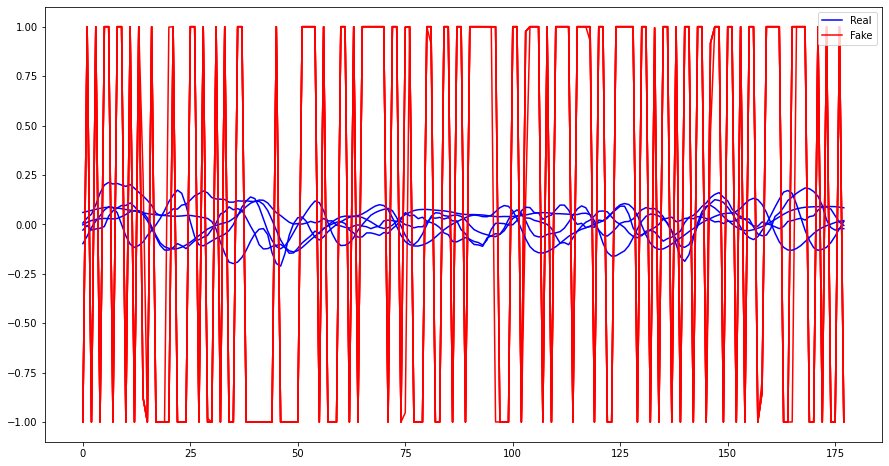

Step 171000: Generator loss: 0.6938449977636337, discriminator loss: 0.7466720704436303


In [47]:
cur_step = 0
generator_loss = []
gen_mean_loss = []
discriminator_loss = [] 
disc_mean_loss = []
for epoch in range(nepochs):

  for batch_idx,(data,label) in enumerate(train_n_loader):

    data, label = data.to(device), label.to(device)
    disc_opt.zero_grad()
    fake_noise = torch.rand(batch_size, z_dim,device=device)
    fake_noise = fake_noise[:,None,:]  #[32,1,64/32]
    
    label_3d = get_one_hot_labels(label.long(),2)
    label_3d = label_3d[:,None,:]  #[32,1,2]
    # print(fake_noise.shape,label_3d.shape)
    noise_and_labels = torch.cat((fake_noise.float(),label_3d.float()),dim=2) # [32,1,66/34]
    fake = gen(noise_and_labels) # [32,1,178]

    ## Make sure that enough time series were generated
    assert len(fake) == len(data) 
    ## It comes from the correct generator
    assert tuple(fake.shape) == (len(data),1,178)  #[32,1,178]

    # raise Exception(fake.shape,label_3d.shape)
    # fake = fake.reshape(len(data),178,1)
    data = data[:,None,:]
    # data = data.reshape(data.shape[0],data.shape[2],data.shape[1])
    # raise Exception(data.shape)
    label_3d = get_one_hot_labels(label.long(),2)
    label_3d = label_3d[:,:,None]
    label_3d = label_3d.repeat(1,1,178)
    fake_ts_and_labels = torch.cat((fake.float(),label_3d.float()),dim=1).detach()
    real_ts_and_labels = torch.cat((data.float(),label_3d.float()),dim=1).detach()
    # raise Exception(fake_ts_and_labels.shape) [32,3,178]
    disc_fake_pred = disc(fake_ts_and_labels)
    disc_real_pred = disc(real_ts_and_labels)
    # raise Exception(disc_fake_pred,disc_real_pred)

    disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
    disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss+disc_real_loss)/2
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    discriminator_loss += [disc_loss.item()]

    ## Update Generator
    gen_opt.zero_grad()
    fake_ts_and_labels = torch.cat((fake.float(),label_3d.float()),dim=1)
    disc_fake_pred = disc(fake_ts_and_labels)
    gen_loss = criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    generator_loss += [gen_loss.item()]

    # raise Exception(max(fake[0][0]),min(fake[0][0]))
    # Print stats
    if cur_step % display_step == 0 and cur_step != 0:
      gen_mean = sum(generator_loss[-display_step:]) / display_step
      disc_mean = sum(discriminator_loss[-display_step:]) / display_step
      gen_mean_loss += [gen_mean]
      disc_mean_loss += [disc_mean]
      print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")

    #if cur_step % 10000 == 0 and cur_step != 0:
    if cur_step % 2000 == 0 and cur_step != 0:
      clear_output(wait=True)
      print("Epoch {}".format(epoch))
      plt.figure(figsize=(15,8))
      #plt.plot(gen_mean_loss, label="generator loss")
      #plt.plot(disc_mean_loss, label="discriminator loss")
      for i in range(5):
        real_label= None
        fake_label= None
        if i == 0:
          real_label = "Real"
          fake_label = "Fake"
        plt.plot(data[-i,0,:], c='b', label=real_label)
        plt.plot(fake.detach().numpy()[i,0,:], c='r', label=fake_label)
      plt.legend(loc=0)
      plt.show()

    
    cur_step += 1

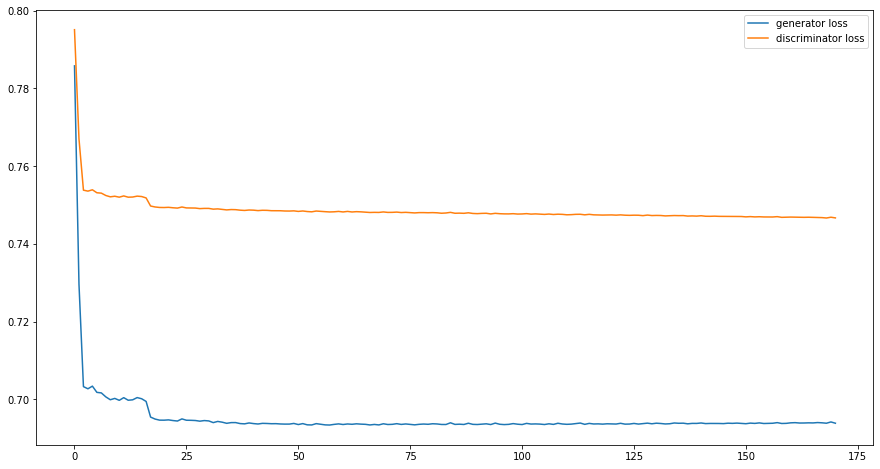

In [48]:
plt.figure(figsize=(15,8))
plt.plot(gen_mean_loss, label="generator loss")
plt.plot(disc_mean_loss, label="discriminator loss")
plt.legend(loc=0)
plt.show()

#### Generated Samples

In [49]:
# noise0_syn = torch.randn(1600,1,64)
noise0_syn = torch.randn(1600,1,32)
label0_syn = torch.zeros(1600,)
label0_syn = get_one_hot_labels(label0_syn.long(),2)
label0_syn = label0_syn[:,None,:]
label0_syn.shape
noise_and_labels0_syn = torch.cat((noise0_syn,label0_syn),dim=2)
noise_and_labels0_syn.shape

torch.Size([1600, 1, 34])

In [50]:
# noise1_syn = torch.randn(1600,1,64)
noise1_syn = torch.randn(1600,1,32)
label1_syn = torch.ones(1600,)
label1_syn = get_one_hot_labels(label1_syn.long(),2)
label1_syn = label1_syn[:,None,:]
label1_syn.shape
noise_and_labels1_syn = torch.cat((noise1_syn,label1_syn),dim=2)

In [51]:
output0_syn = gen(noise_and_labels0_syn)

In [52]:
output1_syn = gen(noise_and_labels1_syn)

In [77]:
def draw_ts_samples(tensor_output,num_samples):
  for i in range(num_samples):
    t = np.arange(0,178)
    x = tensor_output[i].detach().numpy()
    x = x.T
    plt.figure(figsize=(20,8))
    plt.plot(t,x,label="line{}".format(i))
    plt.ylim(-0.5,0.5)
    # plt.ylim(0,1)
    plt.grid()
    plt.legend()

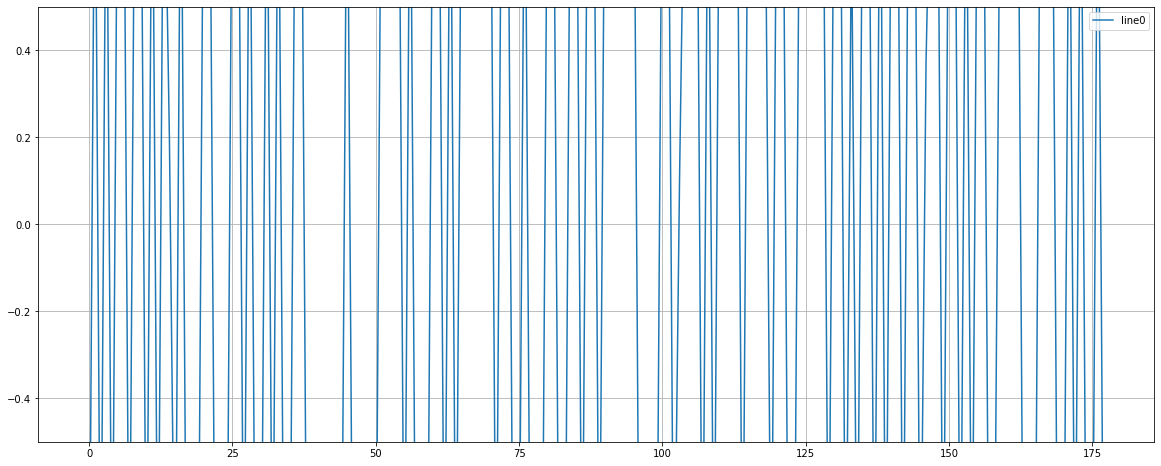

In [78]:
draw_ts_samples(output0_syn,1)

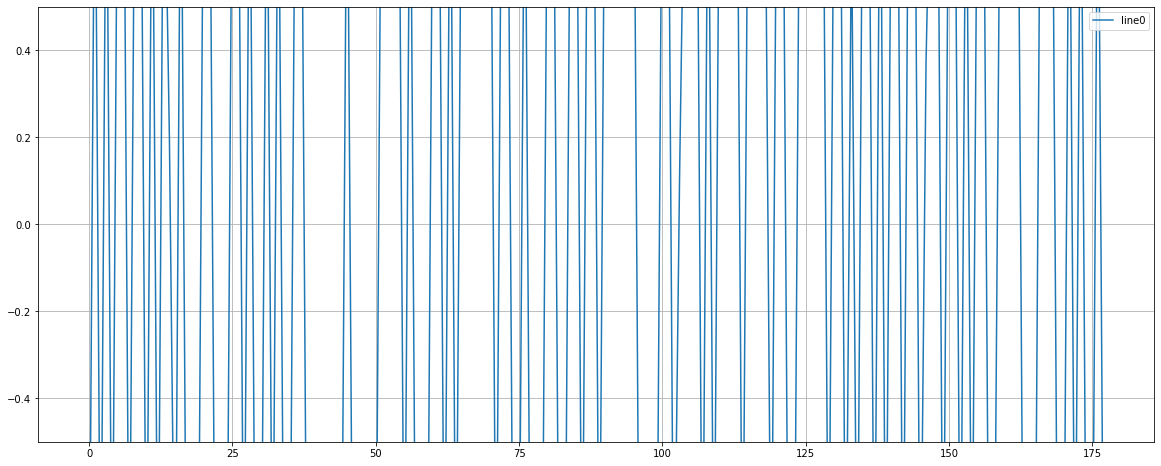

In [79]:
draw_ts_samples(output1_syn,1)

Normalized(Scaled) Generated Time Series.

In [80]:
output0_norm = F.normalize(output0_syn,dim=0)

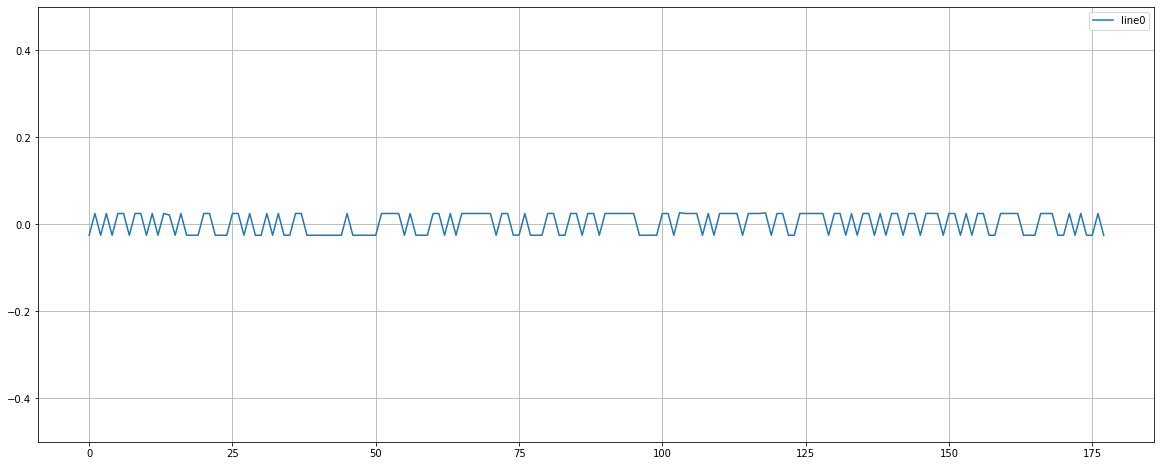

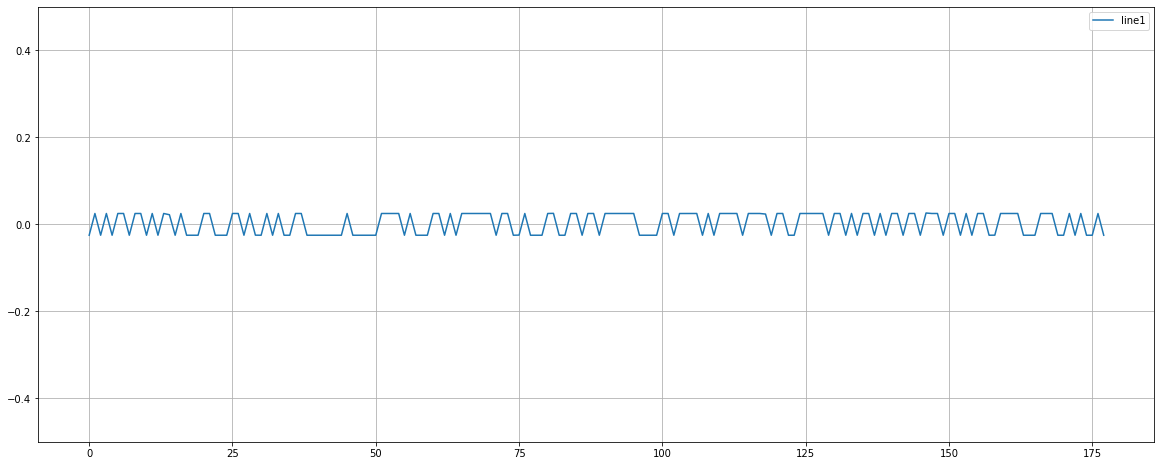

In [81]:
draw_ts_samples(output0_norm,2)

In [82]:
output1_norm = F.normalize(output1_syn,dim=0)

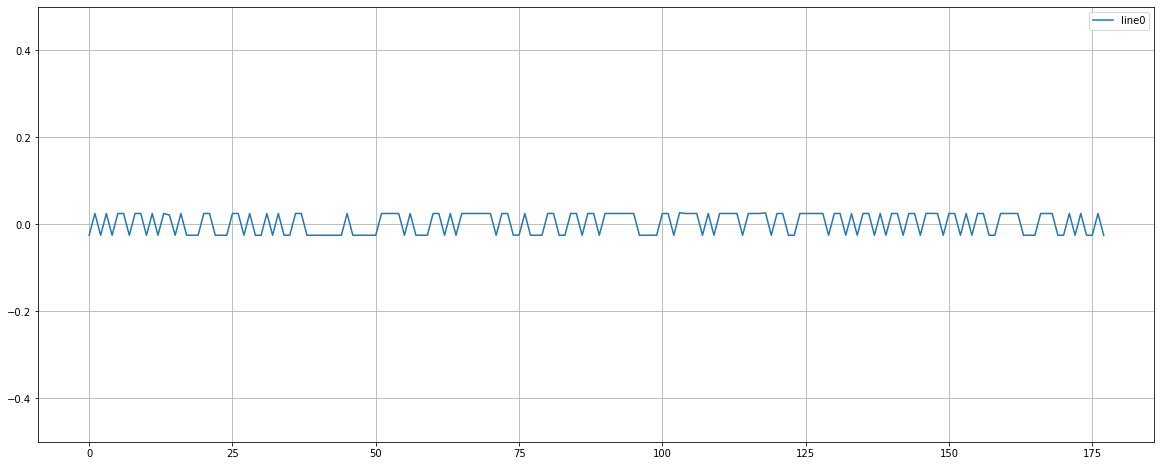

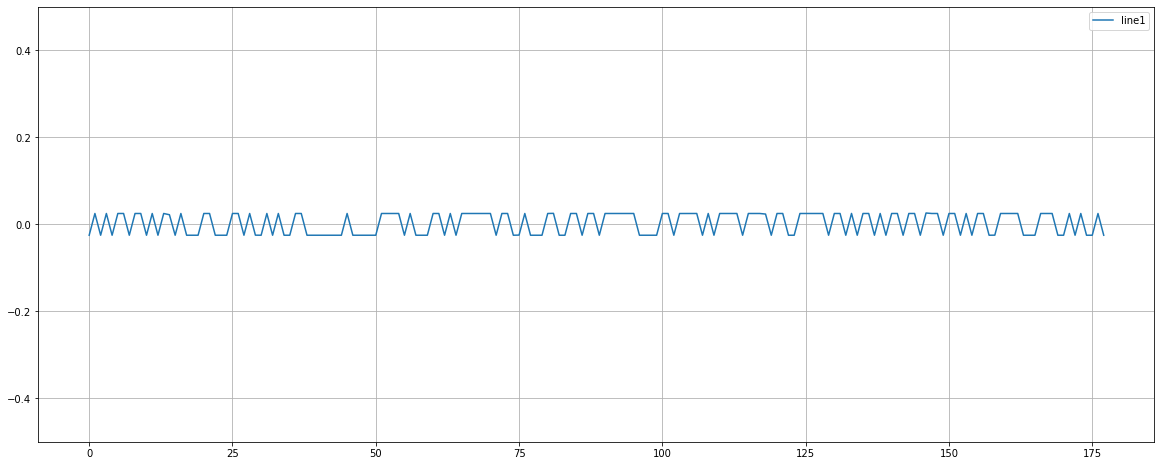

In [83]:
draw_ts_samples(output1_norm,2)

Original Normalized (Scaled) Time Series.

In [60]:
df_norm = df.copy()
df_norm = df_norm.drop(['y'],axis=1)

In [61]:
df_norm.iloc[:,:] = Normalizer(norm='l2').fit_transform(df_norm)
# df_norm.iloc[:,:] = MinMaxScaler(feature_range=[0,1]).fit_transform(df_norm)

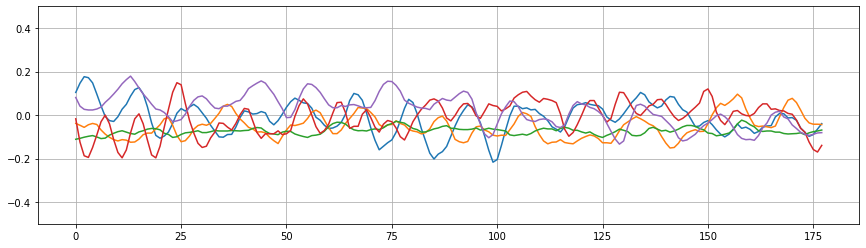

In [62]:
# Non-seizure Normalized Original (1)
plt.figure(figsize=(50,4))
plt.subplot(131)  # 1*3 grid, first subplot
plt.ylim(-0.5,0.5)
# plt.ylim(0,1)
plt.grid()
[plt.plot(df_norm.iloc[i].values) for i in [0,2,3,4,5]];

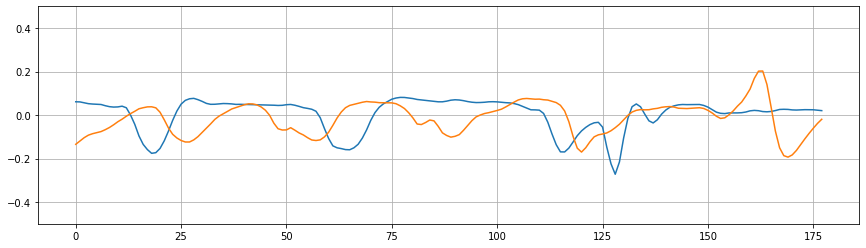

In [63]:
# Seizure Normalized Original (0)
plt.figure(figsize=(50,4))
plt.subplot(131)  # 1*3 grid, first subplot
# plt.ylim(0,1)
plt.ylim(-0.5,0.5)
plt.grid()
[plt.plot(df_norm.iloc[i].values) for i in [1,8]];

### Train Classifier using Generated Data

In [64]:
output0_syn = output0_syn.reshape(output0_syn.shape[0],output0_syn.shape[2])

In [65]:
output1_syn = output0_syn.reshape(output1_syn.shape[0],output1_syn.shape[2])

In [66]:
total_syn = torch.cat((output0_syn,output1_syn),dim=0)
total_syn.shape

torch.Size([3200, 178])

In [67]:
label_syn = torch.cat((torch.zeros(1600),torch.ones(1600)),dim=0)
label_syn.shape

torch.Size([3200])

In [68]:
total_syn_n = F.normalize(total_syn,dim=1)

In [69]:
syn_dataset_n = TensorDataset(total_syn_n,label_syn.long())

In [70]:
type(float(len(syn_dataset_n)))

float

In [71]:
from torch.utils.data import random_split

In [72]:
train_syn_n,val_syn_n = random_split(syn_dataset_n,[1920,1280],generator=torch.Generator().manual_seed(123))

In [73]:
train_synn_loader = torch.utils.data.DataLoader(train_syn_n,batch_size=batch_size,shuffle=True)
val_synn_loader = torch.utils.data.DataLoader(val_syn_n,batch_size=batch_size,shuffle=True)

In [74]:
# maximum number of epoch
numEpochs = 30

# Saving frequency
checkpoint_freq = 10

# Directory for data backup
path = './'

# Accumulators of average costs obtained per epoch
train_losses = []
val_losses = []

# Performance accumulators per epoch
train_accuracies = []
val_accuracies = []

# Model definition
neural_net = NeuralNet()

# Load the model on the chosen device
neural_net = neural_net.to(device)

# Optimizer definition
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 


# Learning loop
for epoch in range(1, numEpochs + 1):
    
    # train the model with the train dataset
    train_loss, train_acc = train_loop(epoch, neural_net, train_synn_loader, optimizer, device)   
    
    # evaluate the model with the validation dataset
    val_loss, val_acc = evaluate(neural_net, val_synn_loader, device)       
    
    # Save the costs obtained
    train_losses.append(train_loss)    
    val_losses.append(val_loss)
    
    # Save the performances
    train_accuracies.append(train_acc)    
    val_accuracies.append(val_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path)

# Save the model at the end of the training
save_model(numEpochs, neural_net, path)
    
print("\n\n\nOptimization ended.\n")

Train Epoch: 1   Avg_Loss: 0.69632   Acc: 948/1920 (49.375%)
Eval:  Avg_Loss: 0.69316   Acc: 642/1280 (50.156%)
Train Epoch: 2   Avg_Loss: 0.69330   Acc: 960/1920 (50.000%)
Eval:  Avg_Loss: 0.69318   Acc: 638/1280 (49.844%)
Train Epoch: 3   Avg_Loss: 0.69363   Acc: 940/1920 (48.958%)
Eval:  Avg_Loss: 0.69318   Acc: 638/1280 (49.844%)
Train Epoch: 4   Avg_Loss: 0.69325   Acc: 962/1920 (50.104%)
Eval:  Avg_Loss: 0.69316   Acc: 638/1280 (49.844%)
Train Epoch: 5   Avg_Loss: 0.69322   Acc: 962/1920 (50.104%)
Eval:  Avg_Loss: 0.69317   Acc: 638/1280 (49.844%)
Train Epoch: 6   Avg_Loss: 0.69323   Acc: 956/1920 (49.792%)
Eval:  Avg_Loss: 0.69314   Acc: 642/1280 (50.156%)
Train Epoch: 7   Avg_Loss: 0.69328   Acc: 952/1920 (49.583%)
Eval:  Avg_Loss: 0.69314   Acc: 642/1280 (50.156%)
Train Epoch: 8   Avg_Loss: 0.69320   Acc: 934/1920 (48.646%)
Eval:  Avg_Loss: 0.69315   Acc: 642/1280 (50.156%)
Train Epoch: 9   Avg_Loss: 0.69336   Acc: 916/1920 (47.708%)
Eval:  Avg_Loss: 0.69314   Acc: 642/1280 (5

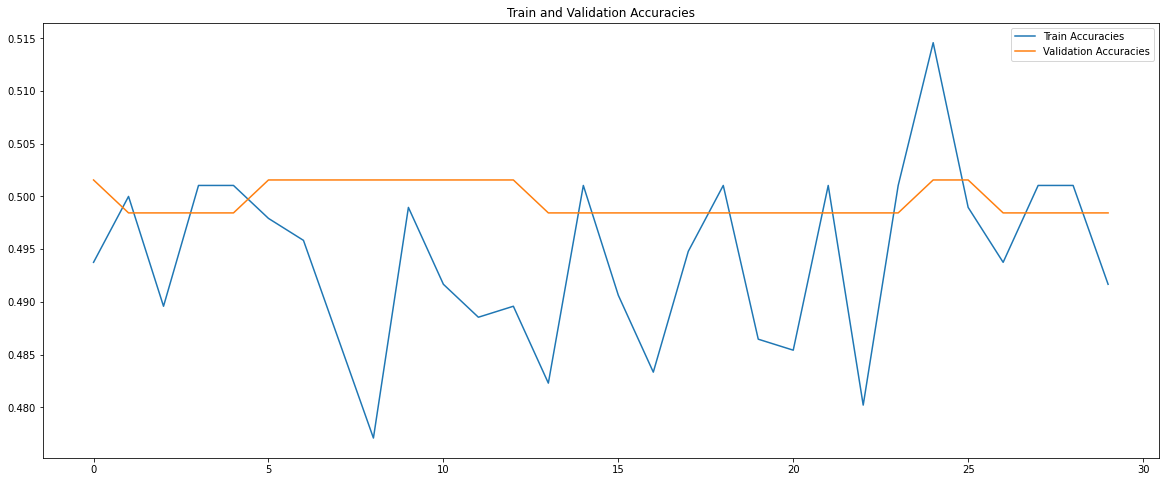

In [75]:
plt.figure(figsize=(20,8))
plt.plot(train_accuracies, label="Train Accuracies")
plt.plot(val_accuracies, label="Validation Accuracies")
plt.title("Train and Validation Accuracies")
plt.legend(loc=0)
plt.show()

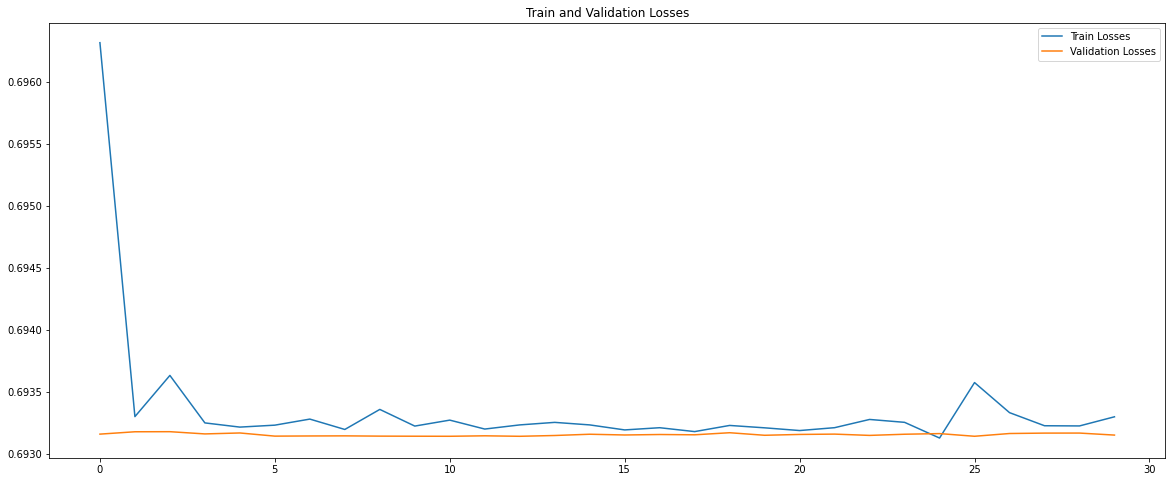

In [76]:
plt.figure(figsize=(20,8))
plt.plot(train_losses, label="Train Losses")
plt.plot(val_losses, label="Validation Losses")
plt.title("Train and Validation Losses")
plt.legend(loc=0)
plt.show()